<a href="https://colab.research.google.com/github/yashpatel5400/schrodinger_op/blob/main/schrodinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!git clone https://github.com/yashpatel5400/schrodinger_op
!apt install -y libfftw3-dev build-essential python3-dev
!pip install shtns --no-build-isolation
import sys
sys.path.append("/content/schrodinger_op/schrodinger_op")

fatal: destination path 'schrodinger_op' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libfftw3-dev is already the newest version (3.3.8-2ubuntu8).
python3-dev is already the newest version (3.10.6-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import argparse
import os
import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import shtns
import numpy as np
from scipy.stats import ttest_rel
import constants
import potentials
import solvers.time_dep
import solvers.spherical
from dataset import construct_dataset, GRF, GRF_spherical

from estimators.linear import LinearEstimator
from estimators.linear_spherical import LinearEstimatorSpherical


from matplotlib import pyplot as plt

[SHTns 3.7.3] built Mar 19 2025, 14:28:41, id: avx2,ishioka,openmp


In [61]:
def add_noise_dataset(samples: np.ndarray, noise_sigma: float) -> np.ndarray:
    if noise_sigma <= 0:
        return samples

    x = samples.copy()
    S, C, N, M = x.shape
    assert C == 2

    norms  = np.linalg.norm(x, axis=(2, 3), keepdims=True) / np.sqrt(N * M)
    scales = noise_sigma * (norms + 1e-14)

    noise = (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape)) * scales
    return x + noise

In [64]:
    potential = "coulomb"
    spherical_coords = potential in ["coulomb", "dipole"] # only Coulomb and dipole potentials use spherical (for now)

    # --- Spherical coordinates constants --- #
    Lmax    = 20   # modes used for projections to/from spherical coordinates (implicitly taken to be N/2 for FFT Euclidean case)
    N_theta = 32   # spatial discretizations (theta/phi)
    N_phi   = 64
    K_sph   = 10   # support of modes for linear estimator


    sph_transform = shtns.sht(Lmax)
    sph_transform.set_grid(N_theta, N_phi)

    # --- Euclidean coordinates constants --- #
    N = 64          # spatial resolution
    L = 2 * np.pi   # spatial domain size
    dx = L/N        # spatial discretization
    K_euc = 16      # support of modes for train/test data (over [-K, K]^d)

    # --- Temporal discretization constants --- #
    T = 0.1         # total time evolution
    num_steps = 50  # temporal resolution (for numerical PDE solver)

    # ----- Generate potentials and train/test initial conditions ----- #
    Vs = {
        "free": potentials.free_particle_potential(N),
        "harmonic_oscillator": potentials.harmonic_oscillator_potential(N, L, omega=2.0, m=constants.m),
        "barrier": potentials.barrier_potential(N, L, barrier_height=50.0, slit_width=0.2),
        "random": potentials.random_potential(N, alpha=1, beta=1, gamma=4),
        "paul_trap": lambda t : potentials.paul_trap(N, L, t, U0=10.0, V0=15.0, omega=3.0, r0=2.0),
        "coulomb": potentials.uniform_sphere(N_theta, N_phi),
        "dipole": potentials.dipole_potential_sphere(N_theta, N_phi),
    }
    V = Vs[potential]

    if spherical_coords:
        solver = lambda psi0 : solvers.spherical.split_step_solver_spherical(V, psi0, sph_transform, T, num_steps)
        #solver = lambda psi0 : solvers.time_dep.solver(V, psi0, N, dx, T, num_steps)
    else:
        solver = lambda psi0 : solvers.time_dep.solver(V, psi0, N, dx, T, num_steps)


    num_train = (Lmax + 1) ** 2 if spherical_coords else (2 * K_euc + 1) ** 2 # (2K+1)^2 to match lin est. sample count
    #num_train = 500
    num_test  = 50

    # np.random.seed(42)
    train_fn = os.path.join(constants.data_dir, potential, "train.npy")
    test_fn  = os.path.join(constants.data_dir, potential, "test.npy")

    if os.path.exists(train_fn) and os.path.exists(test_fn):
        train_samples, test_samples = np.load(train_fn), np.load(test_fn)
    else:
        train_samples, test_samples = [], []
        for sample_idx in range(num_train + num_test):
            print(f"Computing sample: {sample_idx}...")
            if spherical_coords:
                psi0 = GRF_spherical(1, 1, 6, sph_transform)
                #psi0 = GRF(1, 1, 4, N)
            else:
                psi0 = GRF(1, 1, 4, N)

            psiT = solver(psi0)
            if sample_idx < num_train:
                train_samples.append((psi0, psiT))
            else:
                test_samples.append((psi0, psiT))
        train_samples, test_samples = np.array(train_samples), np.array(test_samples)

        os.makedirs(os.path.join(constants.data_dir, potential), exist_ok=True)
        np.save(train_fn, train_samples)
        np.save(test_fn, test_samples)


    noise_sigma=0.001
    train_samples = add_noise_dataset(train_samples, noise_sigma)
    test_samples  = add_noise_dataset(test_samples, noise_sigma)

    if spherical_coords:
      estimator = LinearEstimatorSpherical(solver, sph_transform, K_sph)

    else:
      estimator = LinearEstimator(solver, N, K_euc)






# Time Generalization

(Mean Error, Standard Deviation):
6.257e-04 (1.888e-05)
5.785e-04 (1.783e-05)
5.993e-04 (1.861e-05)
5.985e-04 (1.780e-05)
5.970e-04 (2.068e-05)


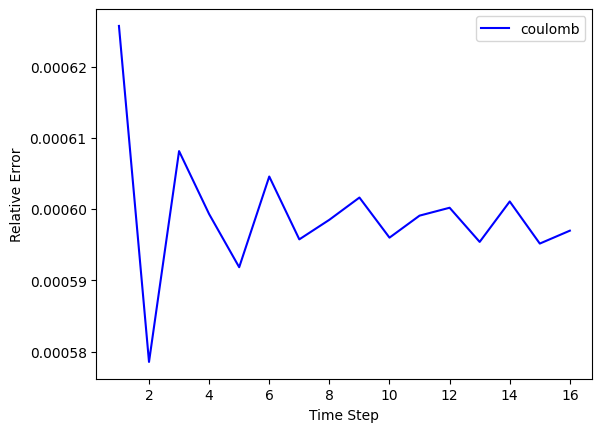

In [65]:
q=16 # number of time steps
time_gen = []
for psi0, _ in test_samples:
    psi_curr = psi0
    lin_est_errors = []
    for j in range(q):
        psi_true = solver(psi_curr)
        psi_lin = estimator.compute_estimate(psi_curr)
        err_lin_num = np.linalg.norm(psi_lin - psi_true)
        err_lin_den = np.linalg.norm(psi_true) + 1e-14
        rel_lin_err = err_lin_num / err_lin_den
        lin_est_errors.append(rel_lin_err)
        psi_curr = psi_true

    time_gen.append(lin_est_errors)

errors = np.mean(time_gen, axis=0)
errors_sd = np.std(time_gen, axis=0)

indices = [0, 1, 3, 7, 15]
indices = [i for i in indices if i < len(errors)]

print("(Mean Error, Standard Deviation):")
for i in indices:
    print(f"{errors[i]:.3e} ({errors_sd[i]:.3e})")




plt.plot(range(1, q+1), errors, color="blue", label=potential)
plt.xlabel("Time Step")
plt.ylabel("Relative Error")
plt.legend()
plt.show()

# Visualization

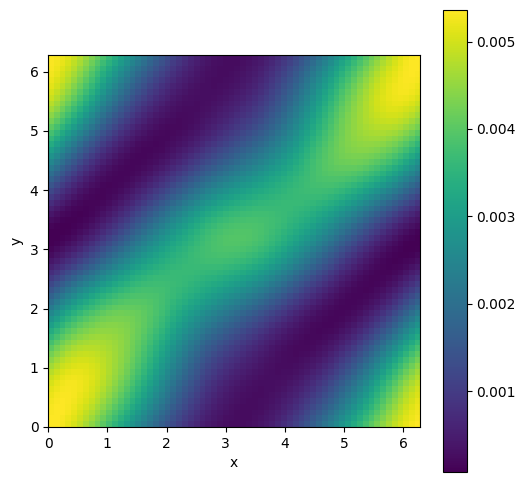

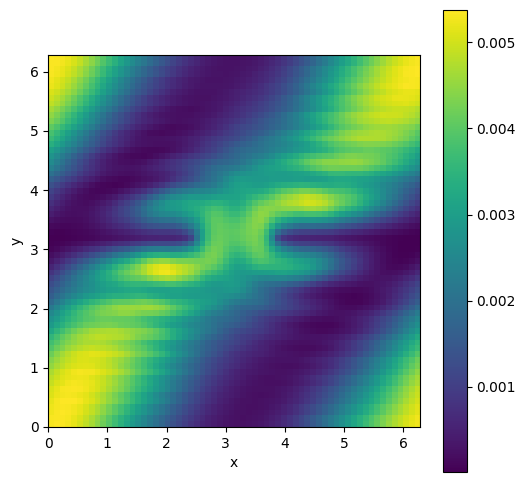

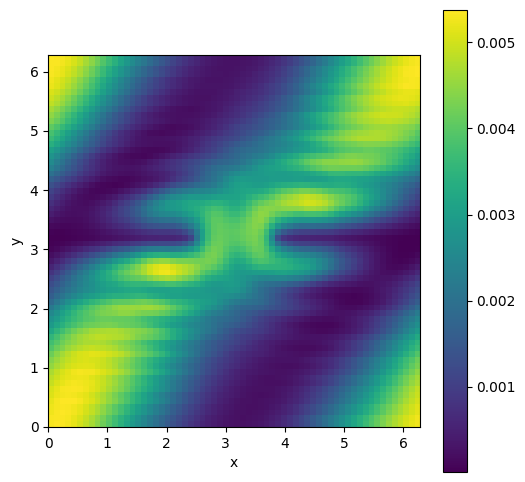

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Select a random test sample
random_index = random.randint(0, len(test_samples) - 1)
input_sample = test_samples[random_index]

output_actual = solver(input_sample[0])
output_pred = estimator.compute_estimate(input_sample[0])

# Ensure N is properly defined
N = input_sample[0].shape[0]  # Assuming square grid (N x N)

x = np.linspace(0, L, N)
y = np.linspace(0, L, N)
X, Y = np.meshgrid(x, y)

# --- Plot Input Function ---
plt.figure(figsize=(6,6))
plt.imshow(np.abs(input_sample[0])**2, extent=[0, L, 0, L], origin='lower', cmap='viridis')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.savefig('input_colormap.png', dpi=300)

# --- Plot Actual Output ---
plt.figure(figsize=(6,6))
plt.imshow(np.abs(output_actual)**2, extent=[0, L, 0, L], origin='lower', cmap='viridis')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.savefig('actual_colormap.png', dpi=300)

# --- Plot Predicted Output ---
plt.figure(figsize=(6,6))
plt.imshow(np.abs(output_pred)**2, extent=[0, L, 0, L], origin='lower', cmap='viridis')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.savefig('predicted_colormap.png', dpi=300)

plt.show()


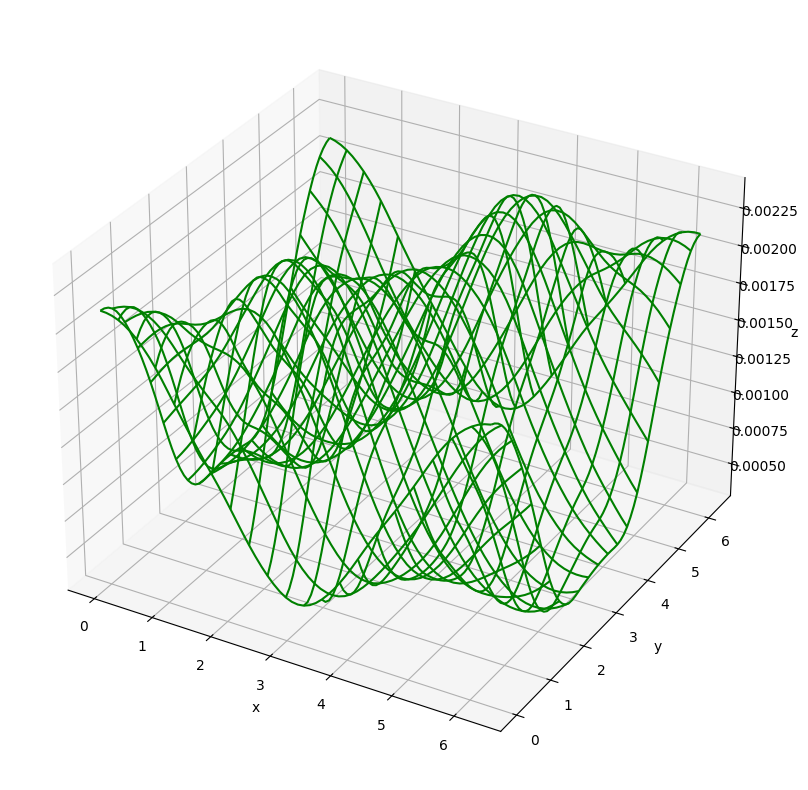

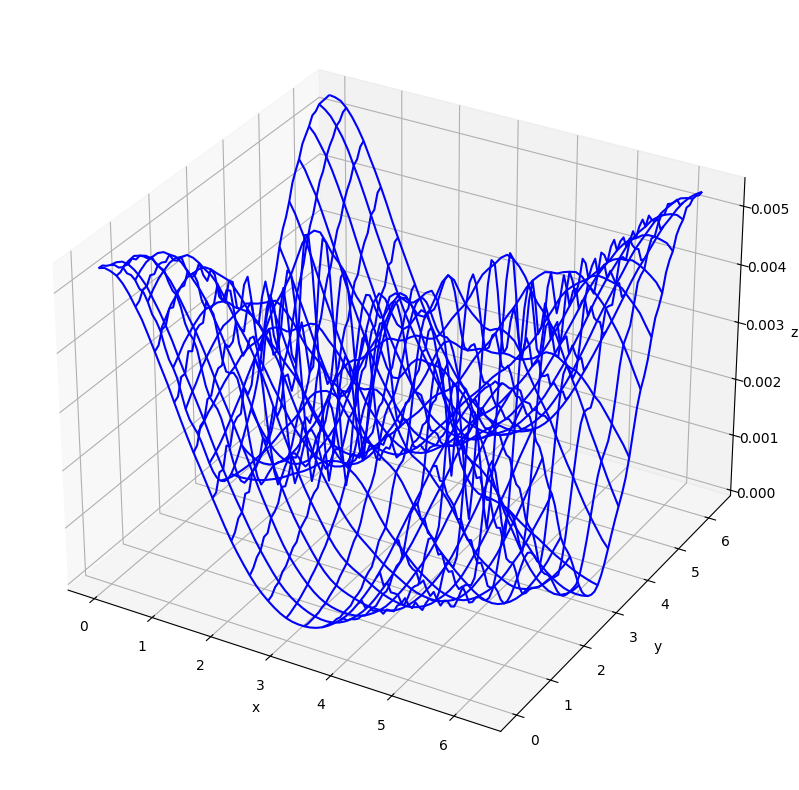

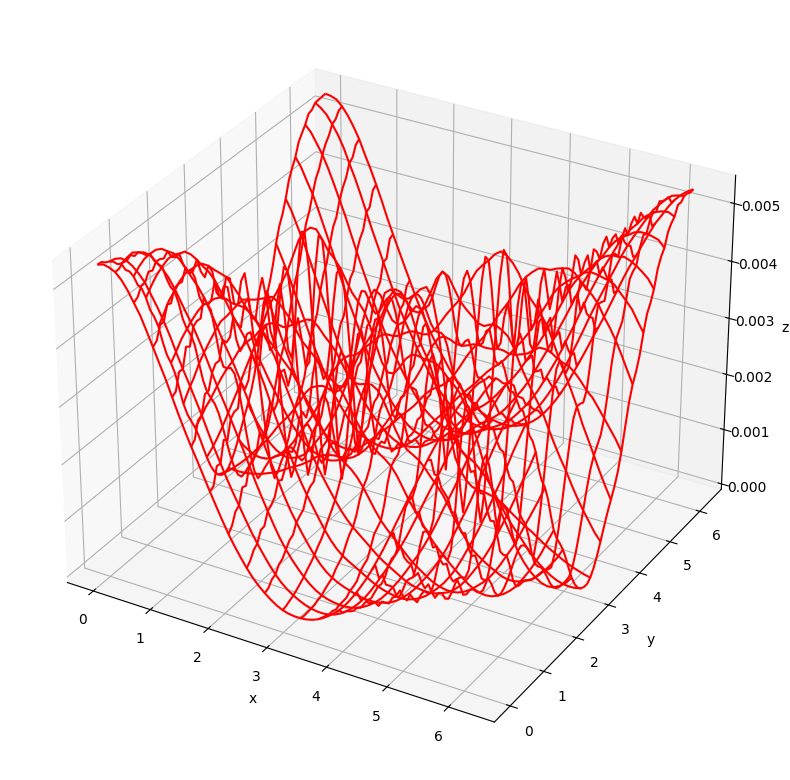

In [ ]:


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(X, Y, np.abs(input[0])**2, color='g', rstride=3, cstride=3, label='Input Actual')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
#ax1.set_title("Input Function")
plt.tight_layout()
plt.savefig('input_3d.png', dpi=300)


# Plot the actual output as a wireframe
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_wireframe(X, Y, np.abs(output_actual)**2, color='b', rstride=3, cstride=3, label='Actual')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
#ax2.set_title("True Output")
plt.tight_layout()
plt.savefig('actual_3d.png', dpi=300)

# Plot the predicted output as a wireframe
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_wireframe(X, Y, np.abs(output_pred)**2, color='r', rstride=3, cstride=3, label='Predicted')
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
#ax3.set_title("Predicted Output")
plt.tight_layout()
plt.savefig('predicted_3d.png', dpi=300)

#Plot the input actual

plt.tight_layout()
plt.show()
